In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import skimage.io
from skimage.transform import resize
from tqdm import trange
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "sklearn\..*" )

%matplotlib inline

### 1.1 Loading data

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                  images_name = "lfw-deepfunneled",
                  dx=80,dy=80,
                  dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt", sep='\t', skiprows=1) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path", "person", "imagenum"], axis=1)
    
    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


#### 1.2 Examining loaded data

In [ ]:
# Types and shapes of loaded datasets

print(f"type(data): {type(data)}, type(attrs): {type(attrs)}\n\
data.shape: {data.shape}, attrs.shape: {attrs.shape}")

type(data): <class 'numpy.ndarray'>, type(attrs): <class 'pandas.core.frame.DataFrame'>
data.shape: (13143, 64, 64, 3), attrs.shape: (13143, 73)


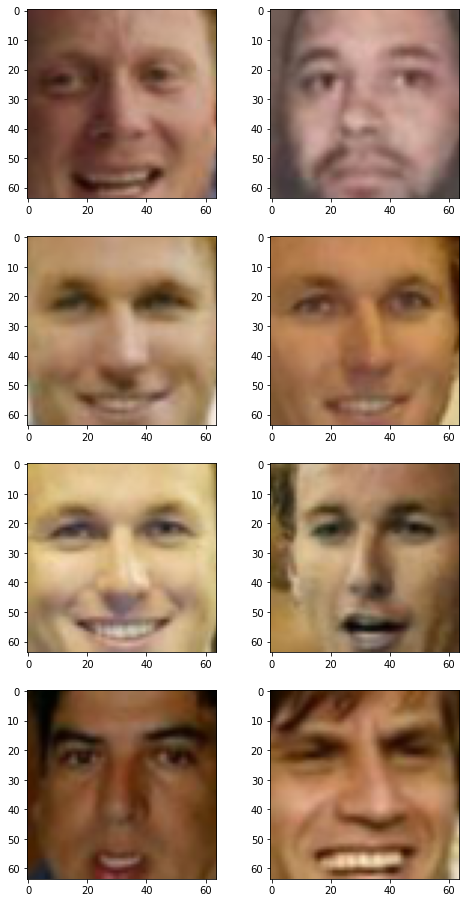

In [ ]:
# Let's look at first 8 faces in the dataset

plt.figure(figsize=(8, 16))

for i in range(1, 9):
    plt.subplot(4, 2, i)
    plt.imshow(data[i])

plt.show()

In [ ]:
# Converting arrays into torch tensors (to be fed into NN). Likewise, tensors can be displayed by plt.imshow()

data = torch.from_numpy(data)

In [ ]:
# Now let's look at the attrs dataframe

attrs.head(3)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231


In [ ]:
# What attributes are presented in the description

attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [10]:
# Splitting on train and validation parts

data_train, data_test, attrs_train, attrs_test = train_test_split(data, attrs, test_size=0.1)
print(f"train size: {data_train.shape[0]}")
print(f"test size: {data_test.shape[0]}")

train size: 11828
test size: 1315


### 2. FC Autoencoder

In [4]:
latent_dim = 16

class FCAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Flattening
        self.flatten = nn.Flatten()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=64*64*3, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=64*64*3)
        )
        
    def forward(self, x):
        latent_x = self.encoder(self.flatten(x).float())
        reconstruction = self.decoder(latent_x).view(-1, 64, 64, 3)
        reconstruction = torch.sigmoid(reconstruction)                    # Why sigmoid actually?? - I think I got it
        
        return reconstruction, latent_x

In [27]:
def AE_MSE_loss(reconstruction, x):               # We use this one
    loss = nn.MSELoss(reduction="mean")

    return loss(reconstruction, x)


def AE_BCE_loss(reconstruction, x):
    loss = nn.BCELoss(reduction="mean")
    
    return loss(reconstruction, x)

In [11]:
# Training preparation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = AE_MSE_loss
model = FCAE().to(device)                                         # maybe FCAE(16): make dimension as an __init__() parameter
optimizer = optim.Adam(model.parameters())


train_loader = data_utils.DataLoader(data_train, batch_size=32)
val_loader = data_utils.DataLoader(data_test, batch_size=32)      

  0%|          | 0/20 [00:00<?, ?it/s]

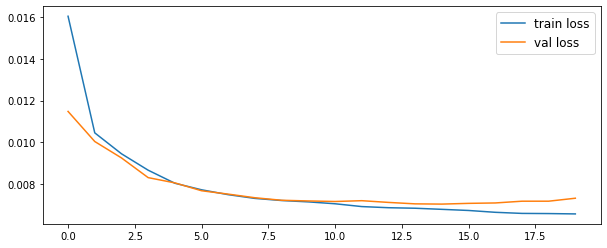

In [ ]:
# Комментарии в trainloop'е - мои неудачные попытки сделать нормальную графику для вывода лоссов

n_epochs = 20
train_losses = list()
val_losses = list()

plt.figure(figsize=(10, 4))

# plt.ion()
# fig, ax = plt.subplots(figsize=(10, 4))
# graph_1 = ax.plot(range(5), range(5))[0]
# graph_2 = ax.plot(range(5), range(5))[0]
# plt.figure(figsize=(10, 4))


for epoch in tqdm(range(n_epochs)):             # trange will add a progress bar

    train_losses_in_epoch = list()
    model.train()
    for i_b, batch in enumerate(train_loader):
        batch = batch.to(device)

        # "Отче наш" / "Our Lord"
        optimizer.zero_grad()
        reconstruction, _ = model(batch)
        loss = criterion(reconstruction, batch.float())
        loss.backward()
        optimizer.step()

        train_losses_in_epoch.append(loss.item())
    
    train_losses.append(np.mean(train_losses_in_epoch))

    val_losses_in_epoch = list()
    model.eval()
    for i_b, batch in enumerate(val_loader):
        batch = batch.to(device)
        reconstruction, _ = model(batch)
        loss = criterion(reconstruction, batch.float())
        val_losses_in_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_in_epoch))

    # ax.clear()
    # ax.plot(train_losses, label="train loss")
    # ax.plot(val_losses, label="val loss")
    # ax.legend()
    # plt.draw()

    # graph_1.set_xdata(range(epoch))
    # graph_1.set_ydata(train_losses)

    # graph_2.set_xdata(range(epoch))
    # graph_2.set_ydata(val_losses)

    # fig.canvas.draw()
    # fig.canvas.flush_events()
    # plt.pause(0.05)

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend(prop={'size': 12})
plt.show()

In [ ]:
# Examine the work of FCAE

model.eval()

with torch.no_grad():
    for batch in val_loader:
        ground_truth = batch.numpy()
        reconstructions, _ = model(batch.to(device))
        reconstructions = reconstructions.cpu().detach().numpy()
        break

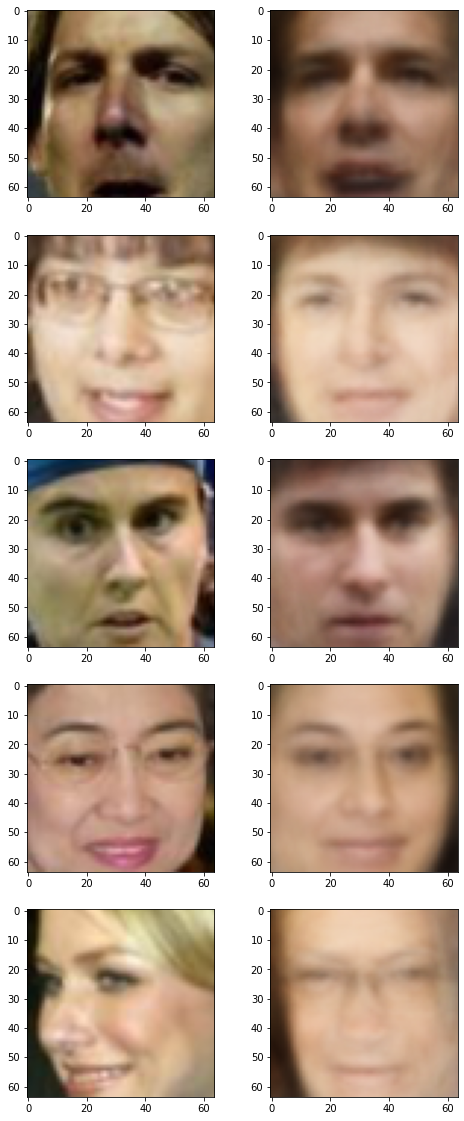

In [ ]:
plt.figure(figsize=(8, 20))

for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstructions[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res)

plt.show()

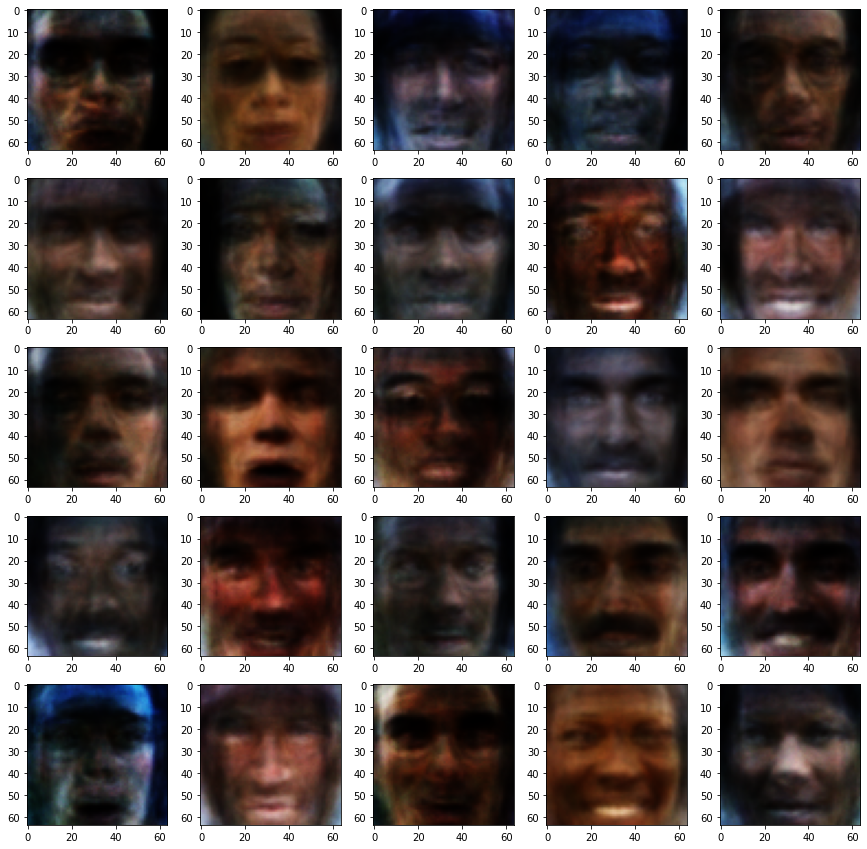

In [ ]:
z = torch.from_numpy(np.random.randn(25, latent_dim)).float().to(device)
samples = torch.sigmoid(model.decoder(z)).view(-1, 64, 64, 3).cpu().detach().numpy()


plt.figure(figsize=(15, 15))

for idx, sample in enumerate(samples):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(sample)

plt.show()

In [ ]:
attrs.head(3)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231


In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:
smile_scores = attrs["Smiling"].astype(float)
merry_mask = smile_scores > 2
gloomy_mask = smile_scores < -2


data_merry = data[merry_mask]
data_gloomy = data[gloomy_mask]

# Loaders
merry_loader = data_utils.DataLoader(data_merry, batch_size=1)
gloomy_loader = data_utils.DataLoader(data_gloomy, batch_size=1)

print(f"The number of \"merry\" photos in data: {data_merry.shape[0]}")
print(f"The number of \"gloomy\" photos in data: {data_gloomy.shape[0]}")

The number of "merry" photos in data: 342
The number of "gloomy" photos in data: 254


In [ ]:
merry_vector = np.zeros(16)
gloomy_vector = np.zeros(16)

model.eval()

with torch.no_grad():
    for pic in merry_loader:
        latent_pic = model.encoder(pic.flatten().to(device).float()).cpu().detach().numpy()          # Нужно прописать поаккуратнее
        merry_vector += latent_pic.squeeze() / len(merry_loader)

with torch.no_grad():
    for pic in gloomy_loader:
        latent_pic = model.encoder(pic.flatten().to(device).float()).cpu().detach().numpy()          # Нужно прописать поаккуратнее
        gloomy_vector += latent_pic.squeeze() / len(gloomy_loader)

smile_vector = torch.from_numpy(merry_vector - gloomy_vector)   # "вектор улыбки"
smile_vector

tensor([ 0.6986, -0.9789, -0.2157,  0.1020,  0.2115, -1.1245, -0.2324,  0.7572,
        -0.7059, -0.8875, -0.4119,  0.5121, -0.3113,  0.0300,  0.6440, -0.6043],
       dtype=torch.float64)

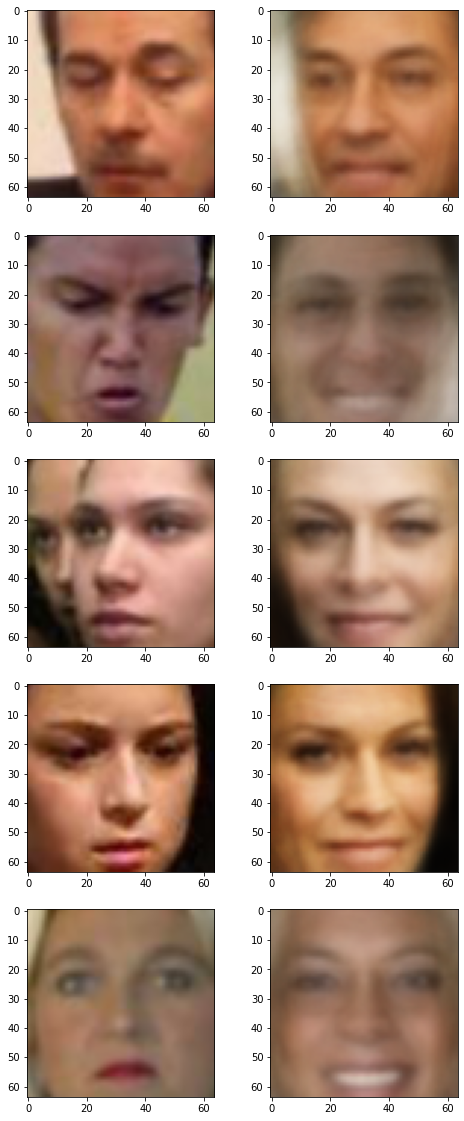

In [ ]:
plt.figure(figsize=(8, 20))

with torch.no_grad():
    k = 0
    for i, pic in enumerate(gloomy_loader):
        latent_pic = model.encoder(pic.flatten().to(device).float())         # Нужно прописать поаккуратнее
        latent_pic += 0.85 * smile_vector.to(device)
        smiled_pic = torch.sigmoid(model.decoder(latent_pic)).view(64, 64, 3).cpu().detach().numpy()

        plt.subplot(5, 2, 2*i + 1)
        plt.imshхуйow(pic.squeeze().cpu().detach().numpy())
        plt.subplot(5, 2, 2*i + 2)
        plt.imshow(smiled_pic)

        k += 10
        if k == 50: break

###2. Variational Autoencoder (VAE)

In [42]:
latent_dim = 64


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            # Conv part
            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),    # -> 32 channels * 64 * 64
            nn.MaxPool2d(kernel_size=2),                                            # -> 32 channels * 32 * 32 
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.2),

            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1),  # -> 128 channels * 32 * 32
            nn.MaxPool2d(kernel_size=2),                                            # -> 128 channels * 16 * 16
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.2),

            # FC part
            nn.Flatten(),                                                           # -> 128 * 16 * 16
            nn.BatchNorm1d(128*16*16),
            nn.Linear(in_features=128*16*16, out_features=512),
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.2),

            nn.BatchNorm1d(512),
            nn.Linear(in_features=512, out_features=128),
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.2),

            nn.BatchNorm1d(128),
            nn.Linear(in_features=128, out_features=latent_dim*2)                   # -> latent_dim * 2                                            
        )

        self.decoder = nn.Sequential(
            # FC part
            nn.Linear(in_features=latent_dim, out_features=512),
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(in_features=512, out_features=128*16*16),

            # UpConv part
            nn.Unflatten(1, (128, 16, 16)),                                                      # -> 128 channels * 16 * 16
            nn.Upsample(scale_factor=2),                                                         # -> 128 channels * 32 * 32
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1),               # -> 32 channels * 32 * 32   transpose -> обычная свертка
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.2),
            
            nn.Upsample(scale_factor=2),                                                         # -> 32 channels * 64 * 64
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),                 # -> 3 channels * 64 * 64

            nn.BatchNorm2d(3),
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            # nn.ReLU(),
            nn.LeakyReLU(negative_slope=0.2),

            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()       
        )

    def reparametrize(self, d_mean, d_log_var):
        std = torch.exp(0.5 * d_log_var)  
        eps = torch.randn_like(std)        # random piece
        sample = d_mean + (eps * std) 

        return sample
    
    def forward(self, x):
        x = x.view(-1, 3, 64, 64) 
        x = self.encoder(x.to(device).float()).view(-1, 2 , latent_dim)
        d_mean = x[:, 0, :]
        d_log_var = x[:, 1, :]

        z = self.reparametrize(d_mean, d_log_var)      
        reconstruction = self.decoder(z)

        return reconstruction, d_mean, d_log_var
    

    def get_sample(self, z):
        sample = self.decoder(z)

        return sample
    
    def get_latent_vector(self, x):
        x = self.encoder(x.to(device).float()).view(-1, 2 , latent_dim)
        d_mean = x[:, 0, :]
        d_log_var = x[:, 1, :]

        z = self.reparametrize(d_mean, d_log_var)
        
        return z

In [43]:
def KL_divergence(d_mean, d_log_var):
    loss = -0.5 * torch.sum(1 + d_log_var - d_mean.pow(2) - d_log_var.exp())

    return loss


def log_likelihood(reconstruction, x):                      # BCE was not working for some reason (giving NaN values)
    loss = nn.BCELoss(reduction="sum")                     

    return loss(reconstruction, x)


def VAE_loss(reconstruction, x, d_mean, d_log_var):
    loss = 0.5 * KL_divergence(d_mean, d_log_var) + 2 * log_likelihood(reconstruction, x)

    return loss

In [44]:
# Training preparation

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = VAE_loss
model = VAE().to(device)                                           # maybe FCAE(16): make dimension as an __init__() parameter
optimizer = optim.Adam(model.parameters(), lr=3e-4)                # Karpathy constant

train_loader = data_utils.DataLoader(data_train, batch_size=32)
val_loader = data_utils.DataLoader(data_test, batch_size=32)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 train loss: 498717.9978885135
Epoch 2 train loss: 488320.71722972975
Epoch 3 train loss: 486142.4232263513
Epoch 4 train loss: 484419.61055743246
Epoch 5 train loss: 482989.82381756755
Epoch 6 train loss: 481854.7075168919
Epoch 7 train loss: 481023.0516047297
Epoch 8 train loss: 480385.54079391895
Epoch 9 train loss: 479868.2238175676
Epoch 10 train loss: 479408.71993243246
Epoch 11 train loss: 479017.93859797297
Epoch 12 train loss: 478686.52119932434
Epoch 13 train loss: 478409.5329391892
Epoch 14 train loss: 478166.09738175676
Epoch 15 train loss: 477953.42795608105
Epoch 16 train loss: 477803.5487331081
Epoch 17 train loss: 477626.28826013516
Epoch 18 train loss: 477447.3222128378
Epoch 19 train loss: 477278.7589527027
Epoch 20 train loss: 477150.94881756755


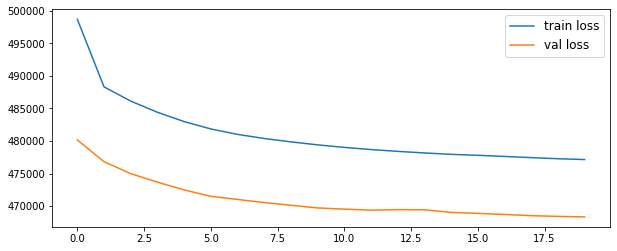

In [45]:
n_epochs = 20
eps = 1e-10
train_losses = list()
val_losses = list()

plt.figure(figsize=(10, 4))


for epoch in tqdm(range(n_epochs)):             # trange will add a progress bar

    train_losses_in_epoch = list()
    model.train()
    for i_b, batch in enumerate(train_loader):
        batch = batch.to(device)

        # "Отче наш" / "Our Lord"
        optimizer.zero_grad()
        reconstruction, p_mean, p_log_var = model(batch)

        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(reconstruction, batch.float(), p_mean, p_log_var)
        loss.backward()
        optimizer.step()

        train_losses_in_epoch.append(loss.item())
    
    print(f"Epoch {epoch + 1} train loss: {np.mean(train_losses_in_epoch)}")
    train_losses.append(np.mean(train_losses_in_epoch))

    val_losses_in_epoch = list()
    model.eval()
    for i_b, batch in enumerate(val_loader):
        batch = batch.to(device)
        reconstruction, p_mean, p_log_var = model(batch)
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(reconstruction, batch.float(), p_mean, p_log_var)
        val_losses_in_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_in_epoch))

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend(prop={'size': 12})
plt.show()

In [ ]:
train_loss_report = {"16->32 channels on the last decoder's layer": 3719,
                     "additional FC layers in encoder + batchnorm on them": 3870,
                     "changed proportions of log_lik and KL in res loss": 6200}

In [24]:
data_train[12].max(axis=(0, 1, 2))    # максимальное значение в тензоре картинки

1.0

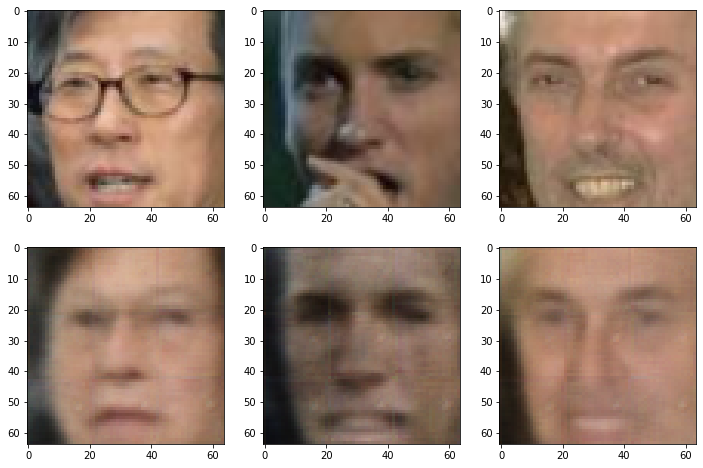

In [46]:
plt.figure(figsize=(12, 8))

model.eval()
with torch.no_grad():
    for batch in val_loader:
        reconstructions, _, _ = model(batch)
        reconstructions = reconstructions.view(-1, 64, 64, 3)
        break

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(batch[i].cpu().detach())
    plt.subplot(2, 3, i+4)
    plt.imshow(reconstructions[i].cpu().detach())

plt.show()

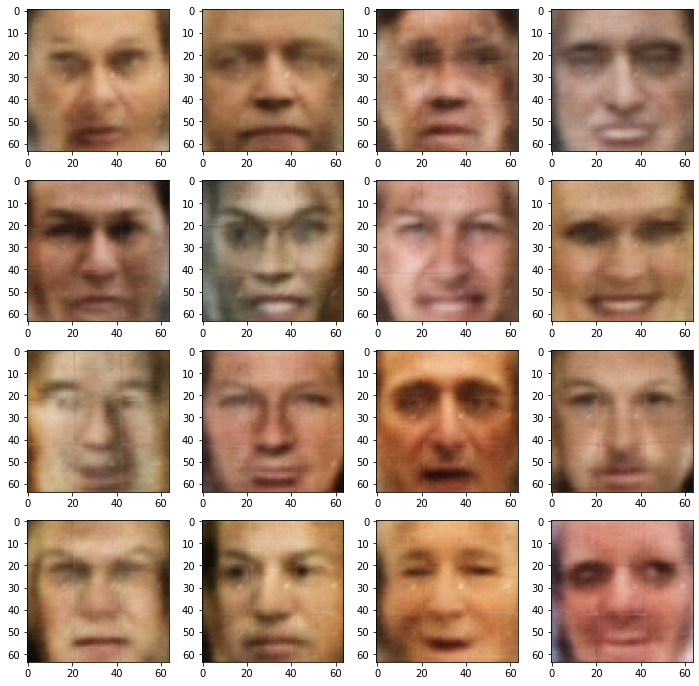

In [48]:
# Попробуем посэмплировать точки из нормального распределения над латентным пространством и посмотрим, что будет на выходе

z = np.array([np.random.normal(0, 1, 64) for i in range(16)])

plt.figure(figsize=(12, 12))

model.eval()
with torch.no_grad():
    reconstruction = model.get_sample(torch.from_numpy(z).float().to(device)).cpu().detach().numpy()

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(reconstruction[i].reshape(64, 64, 3))

plt.show()

In [ ]:
# Сэмплинг по нормальному распределению работает достаточно хорошо. Предположения, почему плохой reconstruction:
# - MSE вместо BCE  (нет)
# - часть ошибки составляет log_likelihood, и эта чатсь мешает учить восстановление  (нет)